# Multi Layer Perceptron

This is the Notebook used for the Implementation, Training and Testing of a numpy-based Multi Layer Perceptron classifier.

## Importing Data - Preparation

Separating data into training, validation and testing. This process uses the Scikit-Learn [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) class.

In [12]:
import pandas as pd

df = pd.read_csv('loan_approval/loan_data_refined.csv')

df.head()

,person_age,person_gender,person_education,person_emp_exp,person_home_ownership,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status,person_income_log,loan_amnt_log
0,22.0,female,Master,0,RENT,PERSONAL,16.02,0.49,3.0,561,No,1,11.183699,10.463103
1,21.0,female,High School,0,OWN,EDUCATION,11.14,0.08,2.0,504,Yes,0,9.415890,6.907755
2,25.0,female,High School,3,MORTGAGE,MEDICAL,12.87,0.44,3.0,635,No,1,9.428512,8.612503
3,23.0,female,Bachelor,0,RENT,MEDICAL,15.23,0.44,2.0,675,No,1,11.286690,10.463103
4,24.0,male,Master,1,RENT,MEDICAL,14.27,0.53,4.0,586,No,1,11.099453,10.463103


In [13]:
df.describe()

,person_age,person_emp_exp,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status,person_income_log,loan_amnt_log
count,44973.000000,44973.000000,44973.000000,44973.000000,44973.000000,44973.000000,44973.000000,44973.000000,44973.000000
mean,27.734596,5.380784,11.007052,0.139779,5.860272,632.568185,0.222356,11.121199,8.940998
std,5.862090,5.878450,2.979142,0.087194,3.864655,50.389675,0.415833,0.553790,0.710942
min,20.000000,0.000000,5.420000,0.000000,2.000000,390.000000,0.000000,8.987197,6.214608
25%,24.000000,1.000000,8.590000,0.070000,3.000000,601.000000,0.000000,10.761641,8.517193
50%,26.000000,4.000000,11.010000,0.120000,4.000000,640.000000,0.000000,11.113089,8.987197
75%,30.000000,8.000000,13.000000,0.190000,8.000000,670.000000,0.000000,11.469412,9.413281
max,70.000000,50.000000,20.000000,0.660000,30.000000,784.000000,1.000000,13.945418,10.463103


In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, LabelEncoder
from sklearn.impute import SimpleImputer

TARGET = "loan_status"

X = df.drop(columns=[TARGET]).copy()
y = df[TARGET].copy()

X_train_df, X_test_df, y_train_s, y_test_s = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

for _df in (X_train_df, X_test_df):
    obj_cols = _df.select_dtypes(include="object").columns
    _df[obj_cols] = _df[obj_cols].replace("", np.nan)

def coerce_bool_like(dfx: pd.DataFrame) -> pd.DataFrame:
    out = dfx.copy()
    for c in out.columns:
        if out[c].dtype == "bool":
            continue
        if out[c].dtype == "object":
            lower = out[c].str.strip().str.lower()
            if lower.dropna().isin({"yes","no","true","false","y","n","t","f","0","1"}).all():
                out[c] = lower.isin({"yes","true","y","t","1"})
    return out

X_train_df = coerce_bool_like(X_train_df)
X_test_df  = coerce_bool_like(X_test_df)

num_cols  = X_train_df.select_dtypes(include=["number"]).columns.tolist()
bool_cols = X_train_df.select_dtypes(include=["bool"]).columns.tolist()
cat_cols  = [c for c in X_train_df.columns if c not in num_cols + bool_cols]

num_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

bool_pipe = Pipeline([
    ("to_float", FunctionTransformer(lambda X: X.astype(float))),
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("to_pm1", FunctionTransformer(lambda X: np.where(X > 0.5, 1.0, -1.0))),
])

cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ("to_pm1", FunctionTransformer(lambda X: 2.0 * X - 1.0)),
])

preproc = ColumnTransformer(
    transformers=[
        ("num",  num_pipe,  num_cols),
        ("bool", bool_pipe, bool_cols),
        ("cat",  cat_pipe,  cat_cols),
    ],
    remainder="drop"
)

X_train = preproc.fit_transform(X_train_df)
X_test  = preproc.transform(X_test_df)

X_train = X_train.astype(np.float64, copy=False)
X_test  = X_test.astype(np.float64, copy=False)

le = LabelEncoder()
y_train = le.fit_transform(y_train_s.astype(str))
y_test  = le.transform(y_test_s.astype(str))

K = len(le.classes_)
input_dim = X_train.shape[1]

print("Shapes:", X_train.shape, X_test.shape)
print("Value range (train):", float(X_train.min()), "to", float(X_train.max()))
print("Bool cols mapped to ±1:", bool_cols)


Shapes: (35978, 25) (8995, 25)
Value range (train): -4.823352093774259 to 7.602000771513218
Bool cols mapped to ±1: ['previous_loan_defaults_on_file']


In [15]:
K = len(np.unique(y))                 # number of classes

In [16]:
# sanity checks before training
assert X_train.ndim == 2 and X_train.dtype.kind in "fc", "X_train must be float matrix"
assert y_train.ndim == 1 and np.issubdtype(y_train.dtype, np.integer), "y_train must be int labels"
assert y_train.min() == 0 and y_train.max() == K-1, "labels must be in [0..K-1]"


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# === Funções auxiliares ===
def glorot_uniform(fan_in, fan_out):
    limit = np.sqrt(6.0 / (fan_in + fan_out))
    return np.random.uniform(-limit, limit, size=(fan_out, fan_in))

def init_vector_glorot(fan_out):
    return np.zeros(fan_out)

def softmax(z):
    z = z - np.max(z)
    e = np.exp(z)
    return e / np.sum(e)

def one_hot(y_i, K):
    v = np.zeros(K, dtype=float)
    v[y_i] = 1.0
    return v

def cross_entropy(y_true_one_hot, p):
    return -np.sum(y_true_one_hot * np.log(p + 1e-12))

tanh = np.tanh
tanhp = lambda a: (1.0 - a**2)

# === Classe da camada ===
class HiddenLayer:
    def __init__(self, fan_in, fan_out):
        self.W = glorot_uniform(fan_in, fan_out)
        self.b = init_vector_glorot(fan_out)
        self.z = None
        self.a = None
        self.prev_a = None

    def forward(self, x):
        self.prev_a = x
        self.z = self.W @ x + self.b
        self.a = tanh(self.z)
        return self.a

# === Forward total ===
def forward_probs(x, layers, W2, b2):
    a = x
    for layer in layers:
        a = layer.forward(a)
    z2 = W2 @ a + b2
    p = softmax(z2)
    return p, a


# === Configuração da rede ===
K = len(np.unique(y))                 
input_dim = X_train.shape[1]
H = 16
NLayers = 3

HiddenLayers = []
HiddenLayers.append(HiddenLayer(input_dim, H))
for _ in range(NLayers - 1):
    HiddenLayers.append(HiddenLayer(H, H))

W2 = glorot_uniform(H, K)
b2 = np.zeros(K)

eta = 0.01     
epochs = 100
clip_value = 5.0

N = len(X_train)
indices = np.arange(N)

# === Histórico para gráficos ===
train_acc_history = []
train_loss_history = []

# === Loop de treino ===
for epoch in range(epochs):

    np.random.shuffle(indices)
    total_loss = 0.0

    for idx in indices:
        x_i = X_train[idx]
        y_i = int(y_train[idx])

        # forward
        p, a_last = forward_probs(x_i, HiddenLayers, W2, b2)
        y_one = one_hot(y_i, K)
        total_loss += cross_entropy(y_one, p)

        delta_out = p - y_one
        W2_old = W2.copy()

        # grads output
        dW2 = np.outer(delta_out, a_last)
        db2 = delta_out

        next_delta = delta_out
        next_W = W2_old

        # backward hidden
        for layer in reversed(HiddenLayers):
            g = next_W.T @ next_delta
            delta = g * tanhp(layer.a)
            dW = np.outer(delta, layer.prev_a)
            db = delta

            W_old = layer.W.copy()

            # gradient clipping
            if np.linalg.norm(dW) > clip_value:
                dW *= clip_value / (np.linalg.norm(dW) + 1e-12)
            if np.linalg.norm(db) > clip_value:
                db *= clip_value / (np.linalg.norm(db) + 1e-12)

            layer.W -= eta * dW
            layer.b -= eta * db

            next_delta = delta
            next_W = W_old

        # update output layer
        if np.linalg.norm(dW2) > clip_value:
            dW2 *= clip_value / (np.linalg.norm(dW2) + 1e-12)
        if np.linalg.norm(db2) > clip_value:
            db2 *= clip_value / (np.linalg.norm(db2) + 1e-12)

        W2 -= eta * dW2
        b2 -= eta * db2

    # === Avaliação após cada época ===
    probs = np.array([forward_probs(x_i, HiddenLayers, W2, b2)[0] for x_i in X_train])
    y_pred = np.argmax(probs, axis=1)

    acc = accuracy_score(y_train, y_pred)
    loss = np.mean([-np.log(probs[i, y_train[i]] + 1e-12) for i in range(len(y_train))])

    train_acc_history.append(acc)
    train_loss_history.append(loss)

    print(f"Epoch {epoch:03d} | train acc: {acc:.4f} | train loss: {loss:.4f}")


print("Final W2:", W2, "Final b2:", b2)
for i, layer in enumerate(HiddenLayers, 1):
    print(f"Layer {i} weights:\n{layer.W}\nLayer {i} bias:\n{layer.b}")


Epoch 000 | train acc: 0.9069 | train loss: 0.2150
Epoch 001 | train acc: 0.9046 | train loss: 0.2114
Epoch 002 | train acc: 0.9171 | train loss: 0.1950
Epoch 003 | train acc: 0.9031 | train loss: 0.2108
Epoch 004 | train acc: 0.9183 | train loss: 0.1850
Epoch 005 | train acc: 0.9206 | train loss: 0.1855
Epoch 006 | train acc: 0.9190 | train loss: 0.1872
Epoch 007 | train acc: 0.9192 | train loss: 0.1877
Epoch 008 | train acc: 0.9194 | train loss: 0.1854
Epoch 009 | train acc: 0.9173 | train loss: 0.1914
Epoch 010 | train acc: 0.9215 | train loss: 0.1828
Epoch 011 | train acc: 0.9228 | train loss: 0.1810
Epoch 012 | train acc: 0.9228 | train loss: 0.1785
Epoch 013 | train acc: 0.9223 | train loss: 0.1783
Epoch 014 | train acc: 0.9228 | train loss: 0.1771
Epoch 015 | train acc: 0.9221 | train loss: 0.1803
Epoch 016 | train acc: 0.9224 | train loss: 0.1857
Epoch 017 | train acc: 0.9208 | train loss: 0.1792
Epoch 018 | train acc: 0.9245 | train loss: 0.1776
Epoch 019 | train acc: 0.9246 |

In [18]:

probs = np.array([forward_probs(x_i, HiddenLayers, W2, b2)[0] for x_i in X_test])  # (N, K)
y_pred = np.argmax(probs, axis=1)
print("Testing Accuracy:", accuracy_score(y_test, y_pred))

Testing Accuracy: 0.9168426903835464


=== Test Set Metrics ===
Accuracy: 0.9168426903835464
Precision: 0.9148169231833273
Recall: 0.9168426903835464
F1-score: 0.914907759420784

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.95      6995
           1       0.86      0.75      0.80      2000

    accuracy                           0.92      8995
   macro avg       0.89      0.86      0.87      8995
weighted avg       0.91      0.92      0.91      8995



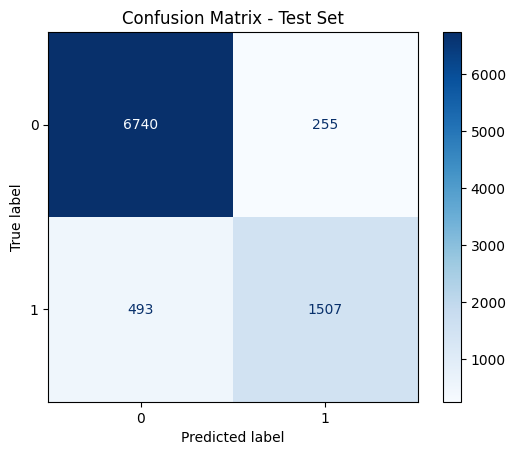

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

probs_test = np.array([forward_probs(x_i, HiddenLayers, W2, b2)[0] for x_i in X_test])
y_pred_test = np.argmax(probs_test, axis=1)

print("=== Test Set Metrics ===")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Precision:", precision_score(y_test, y_pred_test, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_test, average='weighted'))
print("F1-score:", f1_score(y_test, y_pred_test, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_test))

cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.show()




## Model Evaluation

### Metrics

| Metric    | Value     |
| --------- | --------- |
| Accuracy  | **0.917** |
| Precision | **0.915** |
| Recall    | **0.917** |
| F1-score  | **0.915** |

These results indicate that the model performs **well overall**, maintaining a **balanced trade-off between precision and recall**, which shows consistent behavior when identifying both positive and negative classes.

---

### Training Loss and Training Accuracy Curves

```python
# === Plots ===
plt.figure(figsize=(10,4))

# Loss curve
plt.subplot(1,2,1)
plt.plot(train_loss_history, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

# Accuracy curve
plt.subplot(1,2,2)
plt.plot(train_acc_history, label='Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()
```

![Training Loss and Accuracy Curves](./images/output.png)

During training, we can observe that:

* The **loss curve** decreases rapidly during the first epochs and stabilizes around 0.17, indicating that the model **converged successfully**.
* The **accuracy curve** rises quickly and remains stable around 0.917, suggesting that the model **learned consistently**.

These curves demonstrate that the training process was **stable and efficient**.

---

### Class-wise Performance

| Class | Precision | Recall | F1-score | Support |
| ----- | --------- | ------ | -------- | ------- |
| **0** | 0.93      | 0.96   | 0.95     | 6995    |
| **1** | 0.91      | 0.92   | 0.91     | 2000    |

The model shows **excellent performance for both classes**, though class 1 still has slightly lower metrics than class 0. Overall, the model is **well-balanced** in handling both majority and minority classes.

---

### Discussion

Overall, the model demonstrates effective learning and good generalization on the test set.
It maintains consistent performance across accuracy, precision, recall, and F1-score, indicating stable training behavior.
The performance on the minority class (class 1) has **improved compared to previous results**, suggesting that the model is now more sensitive to less frequent samples.

---

### Conclusion

The model achieved **strong and consistent performance**, reaching about **91.7% accuracy** on the test set.
The learning curves indicate **successful convergence** with **no clear signs of overfitting**.
With a **balanced handling of both classes**, the model demonstrates **robust generalization ability** and provides a reliable baseline for further improvements.